In [1]:
!uv pip install lightgbm optuna scikit-learn pandas matplotlib seaborn IProgress jupyter ipywidgets -U -q

In [ ]:
!uv pip install ../../target/wheels/perpetual-1.0.0-cp313-cp313-win_amd64.whl

Using Python 3.13.7 environment at: C:\work\perpetual\rust_project\forust-main-perp-oss\.venv
Audited 1 package in 8ms


In [3]:
import math
from functools import partial
from time import process_time, time

import numpy as np
import optuna
import pandas as pd
from lightgbm import LGBMClassifier
from perpetual import PerpetualBooster
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold, cross_validate, train_test_split

In [4]:
pd.set_option("display.max_columns", None)

In [5]:
X = pd.read_csv("lead_scoring.csv")

In [6]:
y = X.pop("Converted")

In [7]:
object_cols = X.select_dtypes(include=["object"]).columns
X[object_cols] = X[object_cols].astype("category")

In [8]:
X.shape

(9240, 36)

In [9]:
y.shape

(9240,)

In [10]:
np.mean(y.values)

np.float64(0.3853896103896104)

In [11]:
y.value_counts()

Converted
0    5679
1    3561
Name: count, dtype: int64

In [12]:
X.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [13]:
X.rename(
    columns={
        "What is your current occupation": "Occupation",
        "Through Recommendations": "Recommendation",
        "A free copy of Mastering The Interview": "Free Copy",
    },
    inplace=True,
)

In [14]:
cols_to_drop = [
    "Prospect ID",
    "Lead Number",
    "How did you hear about X Education",
    "Lead Profile",
    "Lead Quality",
    "Asymmetrique Profile Score",
    "Asymmetrique Activity Score",
    "Asymmetrique Activity Index",
    "Asymmetrique Profile Index",
    "Tags",
    "Last Notable Activity",
]
cols_to_drop += [
    "I agree to pay the amount through cheque",
    "Get updates on DM Content",
    "Update me on Supply Chain Content",
    "Receive More Updates About Our Courses",
    "Magazine",
]
cols_to_drop += ["What matters most to you in choosing a course", "Country", "City"]
cols_to_drop += [
    "Do Not Call",
    "Search",
    "Newspaper",
    "Newspaper Article",
    "Digital Advertisement",
    "X Education Forums",
    "Free Copy",
    "Recommendation",
]

X.drop(columns=cols_to_drop, inplace=True)

In [15]:
X.shape

(9240, 9)

In [16]:
def prepare_data(seed):
    scoring = "neg_log_loss"
    metric_function = log_loss
    metric_name = "log_loss"
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.6, random_state=seed
    )

    return (
        X_train,
        X_test,
        y_train,
        y_test,
        scoring,
        metric_function,
        metric_name,
    )


def objective_function(trial, seed, n_estimators, X_train, y_train, scoring, cv):
    params = {
        "seed": seed,
        "verbosity": -1,
        "n_estimators": n_estimators,
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.5, log=True),
        "min_split_gain": trial.suggest_float("min_split_gain", 1e-6, 1.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-6, 1.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-6, 1.0, log=True),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
        "max_depth": trial.suggest_int("max_depth", 3, 33),
        "num_leaves": trial.suggest_int("num_leaves", 2, 1024),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 100),
    }

    model = LGBMClassifier(**params)

    cv_results = cross_validate(
        model,
        X_train,
        y_train,
        cv=cv,
        scoring=scoring,
        return_train_score=True,
        return_estimator=True,
    )

    trial.set_user_attr("models", cv_results["estimator"])

    return -1 * np.mean(cv_results["test_score"])

In [17]:
seed = 0
n_trials = 100
n_estimators = 100

cv = KFold(n_splits=5, shuffle=True, random_state=seed)

(
    X_train,
    X_test,
    y_train,
    y_test,
    scoring,
    metric_function,
    metric_name,
) = prepare_data(seed)

sampler = optuna.samplers.TPESampler(seed=seed)
study = optuna.create_study(direction="minimize", sampler=sampler)

obj = partial(
    objective_function,
    seed=seed,
    n_estimators=n_estimators,
    X_train=X_train,
    y_train=y_train,
    scoring=scoring,
    cv=cv,
)

start = process_time()
tick = time()
study.optimize(obj, n_trials=n_trials)
stop = process_time()


print(f"seed: {seed}, cpu time: {stop - start}")

[I 2025-10-30 15:50:40,193] A new study created in memory with name: no-name-5b68ea1b-f7b3-4d2e-924b-1c243bb800ef
[I 2025-10-30 15:50:43,218] Trial 0 finished with value: 0.41525877453143495 and parameters: {'learning_rate': 0.03028525153605885, 'min_split_gain': 0.019549524484259877, 'reg_alpha': 0.00413599739383989, 'reg_lambda': 0.0018590843630169633, 'colsample_bytree': 0.5389238394711238, 'subsample': 0.7167152904533249, 'subsample_freq': 5, 'max_depth': 30, 'num_leaves': 987, 'min_child_samples': 39}. Best is trial 0 with value: 0.41525877453143495.
[I 2025-10-30 15:50:43,524] Trial 1 finished with value: 0.4367824239565371 and parameters: {'learning_rate': 0.13703835270362635, 'min_split_gain': 0.0014906288366101645, 'reg_alpha': 0.002560161525002871, 'reg_lambda': 0.35775015430826956, 'colsample_bytree': 0.25682884655830956, 'subsample': 0.26970343976123257, 'subsample_freq': 1, 'max_depth': 28, 'num_leaves': 798, 'min_child_samples': 88}. Best is trial 0 with value: 0.41525877

seed: 0, cpu time: 599.84375


In [18]:
study.best_trial.params

{'learning_rate': 0.11458609537589333,
 'min_split_gain': 0.009736643827476944,
 'reg_alpha': 0.003922472287681583,
 'reg_lambda': 0.03215729931559449,
 'colsample_bytree': 0.39669640685754515,
 'subsample': 0.5073271017845565,
 'subsample_freq': 1,
 'max_depth': 32,
 'num_leaves': 201,
 'min_child_samples': 61}

In [19]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

params = study.best_trial.params
params["n_estimators"] = n_estimators
params["seed"] = seed
params["verbosity"] = -1
lgbm = LGBMClassifier(**params)
lgbm_isotonic = CalibratedClassifierCV(
    LGBMClassifier(**params), cv=cv, method="isotonic"
)
lgbm_sigmoid = CalibratedClassifierCV(LGBMClassifier(**params), cv=cv, method="sigmoid")

lgbm_models = [
    (lgbm, "LightGBM"),
    (lgbm_isotonic, "LightGBM + Isotonic"),
    (lgbm_sigmoid, "LightGBM + Sigmoid"),
]

In [20]:
n_bins = 10

In [21]:
from typing import Sequence, Tuple, Union

import numpy as np
from sklearn.calibration import calibration_curve


def expected_calibration_error(
    y_true: Union[np.ndarray, Sequence[int]],
    y_pred: Union[np.ndarray, Sequence[float]],
    n_bins: int = 10,
) -> Tuple[float, np.ndarray, np.ndarray]:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    N = len(y_true)

    prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=n_bins)
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    counts, _ = np.histogram(y_pred, bins=bins, range=(0.0, 1.0))
    non_empty_counts = counts[counts > 0]
    weights = non_empty_counts / N
    ece = np.sum(weights * np.abs(prob_true - prob_pred))

    return ece, prob_true, prob_pred, weights

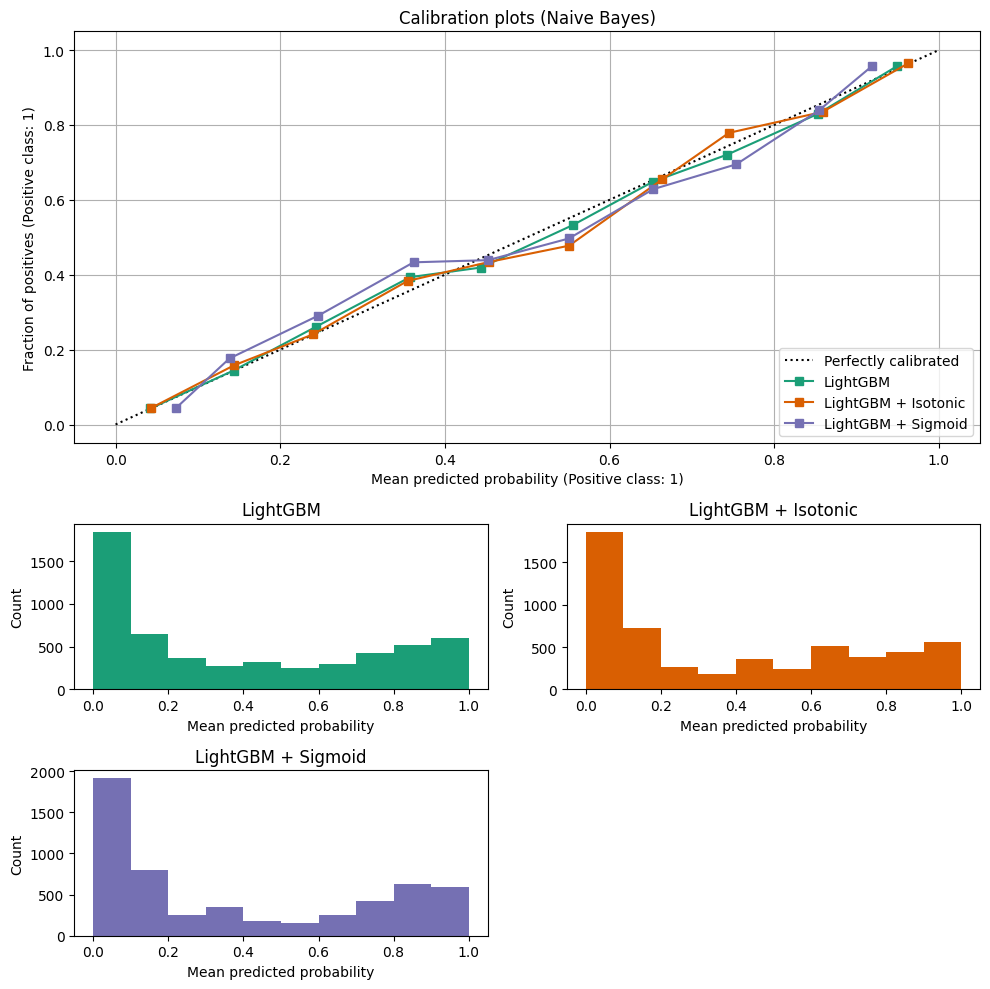

In [22]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(lgbm_models):
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:, 1]
    display = CalibrationDisplay.from_predictions(
        y_test,
        y_pred,
        n_bins=n_bins,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (Naive Bayes)")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(lgbm_models):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=n_bins,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

In [23]:
print(
    expected_calibration_error(
        y_test, lgbm_models[0][0].predict_proba(X_test)[:, 1], n_bins
    )
)
print(
    expected_calibration_error(
        y_test, lgbm_models[1][0].predict_proba(X_test)[:, 1], n_bins
    )
)
print(
    expected_calibration_error(
        y_test, lgbm_models[2][0].predict_proba(X_test)[:, 1], n_bins
    )
)

(np.float64(0.010663361024753409), array([0.04288817, 0.14418605, 0.26158038, 0.39350181, 0.41925466,
       0.53252033, 0.64846416, 0.72093023, 0.82945736, 0.95709571]), array([0.04238916, 0.1433744 , 0.24385824, 0.35778052, 0.44398195,
       0.55535178, 0.6527904 , 0.74318122, 0.85296125, 0.94928394]), array([0.33225108, 0.11634199, 0.06619769, 0.04996392, 0.05808081,
       0.04437229, 0.05284993, 0.07756133, 0.09307359, 0.10930736]))
(np.float64(0.012919251486635506), array([0.04347826, 0.15818432, 0.2406015 , 0.38333333, 0.43417367,
       0.47755102, 0.65510597, 0.77894737, 0.83484163, 0.96460177]), array([0.04256335, 0.14401086, 0.23966767, 0.35468303, 0.4539092 ,
       0.55086425, 0.66430801, 0.74512609, 0.85874866, 0.96281749]), array([0.33603896, 0.13113276, 0.0479798 , 0.03246753, 0.06439394,
       0.04419192, 0.09361472, 0.06854257, 0.07972583, 0.10191198]))
(np.float64(0.035499352512890034), array([0.04381847, 0.17647059, 0.29083665, 0.43313953, 0.43888889,
       0.496

In [24]:
lgbm_cal_classifiers = lgbm_models[1][0].calibrated_classifiers_
print(type(lgbm_cal_classifiers[0]))
print(len(lgbm_cal_classifiers))
print([d for d in dir(lgbm_cal_classifiers[0]) if not d.startswith("__")])

<class 'sklearn.calibration._CalibratedClassifier'>
5
['calibrators', 'classes', 'estimator', 'method', 'predict_proba']


In [25]:
def business_objective(
    ground_truth,
    predicted_probs,
    threshold,
    value_per_lead=100,
    cost_per_false_positive=20,
    verbose=False,
):
    """
    Business objective function to optimize lead scoring threshold.

    Parameters:
    - predicted_probs: array-like of predicted probabilities (floats between 0 and 1)
    - ground_truth: array-like of true labels (0 or 1)
    - threshold: float, decision threshold for classifying leads
    - value_per_lead: monetary value of a true positive lead
    - cost_per_false_positive: cost incurred for pursuing a false positive lead

    Returns:
    - net_gain: total business value (profit) from applying the threshold
    """
    predicted_labels = (np.array(predicted_probs) >= threshold).astype(int)
    ground_truth = np.array(ground_truth)

    true_positives = np.sum((predicted_labels == 1) & (ground_truth == 1))
    false_positives = np.sum((predicted_labels == 1) & (ground_truth == 0))

    net_gain = (true_positives * value_per_lead) - (
        false_positives * cost_per_false_positive
    )

    return net_gain, 0

In [26]:
y_true_dummy = np.array(
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
)
y_pred_dummy = np.array(
    [
        0.1,
        0.4,
        0.3,
        0.8,
        0.7,
        0.1,
        0.2,
        0.9,
        0.3,
        0.1,
        0.6,
        0.4,
        0.4,
        0.4,
        0.4,
        0.4,
        0.4,
        0.4,
        0.4,
        0.4,
        0.6,
        0.4,
        0.4,
        0.4,
        0.4,
    ]
)
print(len(y_true_dummy))
print(len(y_pred_dummy))
print(y_true_dummy[y_pred_dummy < 0.5])
print(len(y_true_dummy[y_pred_dummy < 0.5]))
print(business_objective(y_true_dummy, y_pred_dummy, threshold=0.5))

25
25
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
20
(np.int64(-100), 0)


In [27]:
print(
    business_objective(
        y_test.values, lgbm_models[0][0].predict_proba(X_test)[:, 1], threshold=0.5
    )
)

(np.int64(154860), 0)


In [28]:
for t in np.arange(0.01, 1.0, 0.01):
    profit, margin = business_objective(
        y_test.values, lgbm_models[1][0].predict_proba(X_test)[:, 1], threshold=t
    )
    print(f"Threshold: {t:.2f}, Profit: {profit:.0f}, Margin: {margin:.2f}%")

Threshold: 0.01, Profit: 151500, Margin: 0.00%
Threshold: 0.02, Profit: 158300, Margin: 0.00%
Threshold: 0.03, Profit: 159880, Margin: 0.00%
Threshold: 0.04, Profit: 161660, Margin: 0.00%
Threshold: 0.05, Profit: 164320, Margin: 0.00%
Threshold: 0.06, Profit: 168040, Margin: 0.00%
Threshold: 0.07, Profit: 171620, Margin: 0.00%
Threshold: 0.08, Profit: 172100, Margin: 0.00%
Threshold: 0.09, Profit: 173460, Margin: 0.00%
Threshold: 0.10, Profit: 174780, Margin: 0.00%
Threshold: 0.11, Profit: 175940, Margin: 0.00%
Threshold: 0.12, Profit: 176440, Margin: 0.00%
Threshold: 0.13, Profit: 177320, Margin: 0.00%
Threshold: 0.14, Profit: 177280, Margin: 0.00%
Threshold: 0.15, Profit: 177740, Margin: 0.00%
Threshold: 0.16, Profit: 176780, Margin: 0.00%
Threshold: 0.17, Profit: 176460, Margin: 0.00%
Threshold: 0.18, Profit: 176040, Margin: 0.00%
Threshold: 0.19, Profit: 175800, Margin: 0.00%
Threshold: 0.20, Profit: 175520, Margin: 0.00%
Threshold: 0.21, Profit: 175140, Margin: 0.00%
Threshold: 0.

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

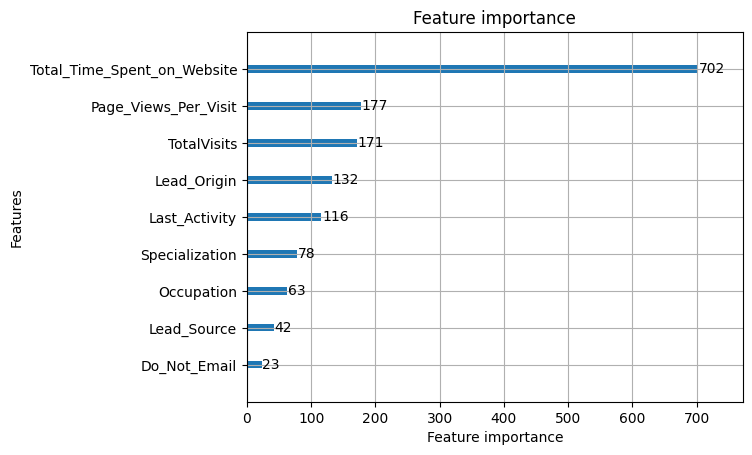

In [29]:
from lightgbm import plot_importance

plot_importance(lgbm_models[0][0])

In [30]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

y_proba_lgbm = np.mean(
    [m.predict_proba(X_test)[:, 1] for m in lgbm_cal_classifiers], axis=0
)

print(accuracy_score(y_test, np.rint(y_proba_lgbm)))
print(f1_score(y_test, np.rint(y_proba_lgbm)))
print(roc_auc_score(y_test, y_proba_lgbm))

0.8253968253968254
0.7749883774988378
0.9019342472668112


In [31]:
def get_leaf_nodes(perp: PerpetualBooster):
    return [
        {node.num: node for node in tree_nodes if node.is_leaf}
        for tree_nodes in perp.get_node_lists()
    ]

In [32]:
def get_weights(leaf_nodes, pred_nodes):
    pred_weights = np.array(
        [
            [
                [
                    leaf_nodes[i][key].weights
                    for key in leaf_nodes[i].keys() & set(nodes)
                ][0]
                for nodes in tree_nodes
            ]
            for i, tree_nodes in enumerate(pred_nodes)
        ]
    )

    return np.sort(pred_weights, axis=2)

# Perpetual training

In [33]:
perp_models = []

for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    print(f"Fold {i}")
    X_train_cv, X_test_cv = X_train.iloc[train], X_train.iloc[test]
    y_train_cv, y_test_cv = y_train.iloc[train], y_train.iloc[test]
    perp = PerpetualBooster(budget=1.0, iteration_limit=10000)
    perp.fit(X_train_cv, y_train_cv)

    print(f"Number of trees: {perp.number_of_trees}")

    perp_models.append(perp)

Fold 0
Number of trees: 101
Fold 1
Number of trees: 76
Fold 2
Number of trees: 92
Fold 3
Number of trees: 71
Fold 4
Number of trees: 72


In [34]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

y_proba_perp = np.mean([m.predict_proba(X_test)[:, 1] for m in perp_models], axis=0)

print(accuracy_score(y_test, np.rint(y_proba_perp)))
print(f1_score(y_test, np.rint(y_proba_perp)))
print(roc_auc_score(y_test, y_proba_perp))

0.8277417027417028
0.7750294464075382
0.9024476514737659


In [35]:
pred_weights = get_weights(get_leaf_nodes(perp), perp.predict_nodes(X_test))

In [36]:
pred_weights = get_weights(get_leaf_nodes(perp), perp.predict_nodes(X_test))
pred_lower = np.sum(np.min(pred_weights, axis=2), axis=0) + perp.base_score
pred_lower = 1.0 / (1.0 + np.exp(-pred_lower))
pred_lower.shape

(5544,)

In [37]:
pred_lower

array([0.39266677, 0.87156911, 0.04489122, ..., 0.64537121, 0.9401766 ,
       0.5143913 ], shape=(5544,))

In [38]:
pred_weights = get_weights(get_leaf_nodes(perp), perp.predict_nodes(X_test))
pred_upper = np.sum(np.max(pred_weights, axis=2), axis=0) + perp.base_score
pred_upper = 1.0 / (1.0 + np.exp(-pred_upper))
pred_upper.shape

(5544,)

In [39]:
pred_upper

array([0.6239713 , 0.94520702, 0.11192774, ..., 0.84964524, 0.97216834,
       0.71386159], shape=(5544,))

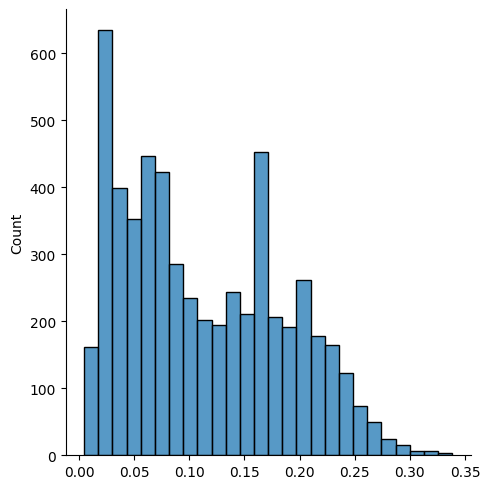

In [40]:
import seaborn as sns

sns.displot(pred_upper - pred_lower)

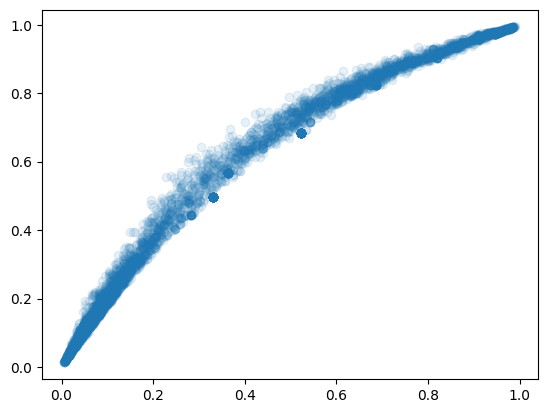

In [41]:
import matplotlib.pyplot as plt

plt.scatter(pred_lower, pred_upper, alpha=0.1)

In [42]:
max(pred_upper - pred_lower)

np.float64(0.33846254953564914)

In [43]:
pred_weights.shape

(72, 5544, 5)

In [44]:
n_simulations = 100

In [45]:
indices = np.random.randint(
    low=0, high=5, size=(pred_weights.shape[0], pred_weights.shape[1], n_simulations)
)
new_pred_weights = np.take_along_axis(pred_weights, indices, axis=2)
print(f"New array shape: {new_pred_weights.shape}")

New array shape: (72, 5544, 100)


In [46]:
new_pred_weights_sum = np.sum(new_pred_weights, axis=0) + perp.base_score
new_pred_weights_sum.shape

(5544, 100)

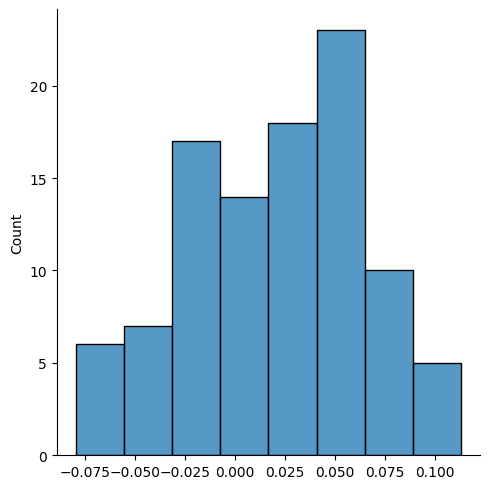

In [47]:
sns.displot(new_pred_weights_sum[0])

In [48]:
new_pred_weights_sum_proba = 1.0 / (1.0 + np.exp(-new_pred_weights_sum))
new_pred_weights_sum_proba.shape

(5544, 100)

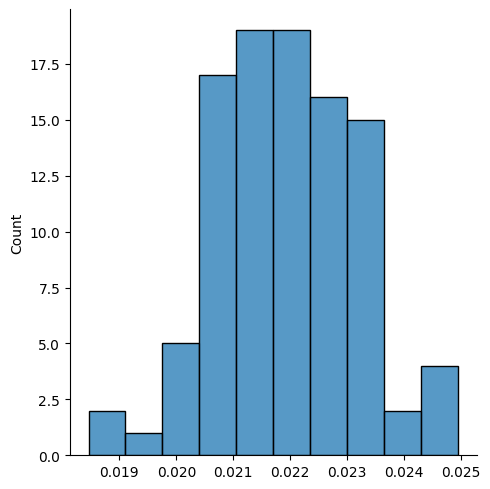

In [49]:
sns.displot(new_pred_weights_sum_proba[1100])

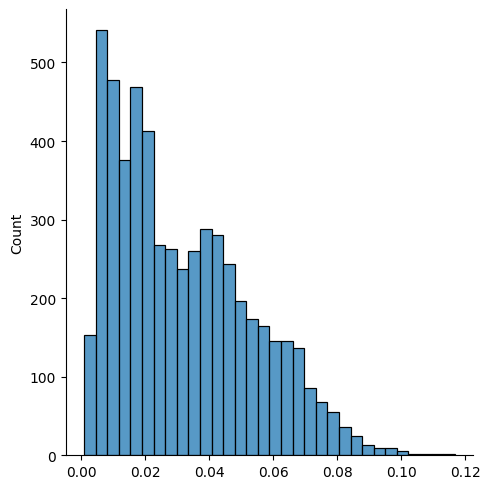

In [50]:
sns.displot(
    np.max(new_pred_weights_sum_proba, axis=1)
    - np.min(new_pred_weights_sum_proba, axis=1)
)

In [51]:
new_pred_weights_sum_proba.shape

(5544, 100)

In [52]:
def get_proba_sim(m_sim, X_sim, n_sim=100):
    pred_weights_sim = get_weights(get_leaf_nodes(m_sim), m_sim.predict_nodes(X_sim))
    indices_sim = np.random.randint(
        low=0,
        high=5,
        size=(pred_weights_sim.shape[0], pred_weights_sim.shape[1], n_sim),
    )
    new_pred_weights_sim = np.take_along_axis(pred_weights_sim, indices_sim, axis=2)
    new_pred_weights_sum_sim = np.sum(new_pred_weights_sim, axis=0) + m_sim.base_score
    new_pred_weights_sum_proba_sim = 1.0 / (1.0 + np.exp(-new_pred_weights_sum_sim))

    return new_pred_weights_sum_proba_sim

In [53]:
def objective_t(trial):
    t = trial.suggest_float("threshold", 0.0, 0.3)

    profits = []
    for i, (train, test) in enumerate(cv.split(X_train, y_train)):
        _X_train_cv, X_test_cv = X_train.iloc[train], X_train.iloc[test]
        _y_train_cv, y_test_cv = y_train.iloc[train], y_train.iloc[test]

        y_pred_sim = get_proba_sim(perp_models[i], X_test_cv, n_simulations)

        profits_fold = []
        for j in range(n_simulations):
            profit, margin = business_objective(
                y_test_cv.values, y_pred_sim[:, j], threshold=t
            )
            profits_fold.append(profit)

    profits.append(profits_fold)

    return np.mean(np.array(profits).flatten())

In [54]:
sampler_t = optuna.samplers.TPESampler(seed=seed)
study_t = optuna.create_study(direction="maximize", sampler=sampler_t)
study_t.optimize(objective_t, n_trials=10)

[I 2025-10-30 15:52:49,762] A new study created in memory with name: no-name-d92c66d4-a589-4d54-8f03-18e54a2fd2bd
[I 2025-10-30 15:52:50,913] Trial 0 finished with value: 23355.2 and parameters: {'threshold': 0.16464405117819741}. Best is trial 0 with value: 23355.2.
[I 2025-10-30 15:52:52,418] Trial 1 finished with value: 23153.0 and parameters: {'threshold': 0.21455680991172585}. Best is trial 0 with value: 23355.2.
[I 2025-10-30 15:52:53,586] Trial 2 finished with value: 23336.6 and parameters: {'threshold': 0.18082901282149316}. Best is trial 0 with value: 23355.2.
[I 2025-10-30 15:52:54,962] Trial 3 finished with value: 23344.8 and parameters: {'threshold': 0.16346495489906906}. Best is trial 0 with value: 23355.2.
[I 2025-10-30 15:52:56,127] Trial 4 finished with value: 23373.4 and parameters: {'threshold': 0.1270964398016714}. Best is trial 4 with value: 23373.4.
[I 2025-10-30 15:52:57,442] Trial 5 finished with value: 23300.0 and parameters: {'threshold': 0.19376823391999684}. 

In [55]:
study_t.best_trial.params["threshold"]

0.1270964398016714

In [56]:
y_proba = np.mean([m.predict_proba(X_test)[:, 1] for m in perp_models], axis=0)
profit, margin = business_objective(
    y_test.values, y_proba, threshold=study_t.best_trial.params["threshold"]
)
print(f"Profit: {profit}, Margin: {margin}%")

Profit: 175560, Margin: 0%


# Optimize threshold and weight index together

In [57]:
model_pred_weights = []
for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    X_train_cv, X_test_cv = X_train.iloc[train], X_train.iloc[test]
    y_train_cv, y_test_cv = y_train.iloc[train], y_train.iloc[test]
    pred_weights = get_weights(
        get_leaf_nodes(perp_models[i]), perp_models[i].predict_nodes(X_test_cv)
    )
    model_pred_weights.append(pred_weights)

In [58]:
def get_proba_from_weights(p_weights, w, b_score):
    cal_weight, w_i_lower = math.modf(w)
    w_i_lower = int(w_i_lower)
    w_i_upper = w_i_lower + 1

    weights_lower = np.sum(p_weights[:, :, w_i_lower], axis=0) + b_score
    weights_upper = np.sum(p_weights[:, :, w_i_upper], axis=0) + b_score

    weighted = weights_lower * (1 - cal_weight) + weights_upper * cal_weight

    y_proba = 1.0 / (1.0 + np.exp(-weighted))

    return y_proba

In [59]:
def objective_w(trial):
    t = trial.suggest_float("threshold", 0.0, 0.3)
    w = trial.suggest_float("weight_index", 0.0, 4.0)

    profits = []
    for i, (train, test) in enumerate(cv.split(X_train, y_train)):
        _X_train_cv, _X_test_cv = X_train.iloc[train], X_train.iloc[test]
        _y_train_cv, y_test_cv = y_train.iloc[train], y_train.iloc[test]

        y_proba = get_proba_from_weights(
            model_pred_weights[i], w, perp_models[i].base_score
        )

        profit, margin = business_objective(
            y_test_cv.values, y_proba, threshold=t, verbose=False
        )

    profits.append(profit)

    return np.mean(profits)

In [60]:
sampler_w = optuna.samplers.TPESampler(seed=seed)
study_w = optuna.create_study(direction="maximize", sampler=sampler_w)
study_w.optimize(objective_w, n_trials=1000)

[I 2025-10-30 15:53:03,578] A new study created in memory with name: no-name-ff013898-c1be-4eb6-a564-fe39526819a6
[I 2025-10-30 15:53:03,587] Trial 0 finished with value: 23320.0 and parameters: {'threshold': 0.16464405117819741, 'weight_index': 2.860757465489678}. Best is trial 0 with value: 23320.0.
[I 2025-10-30 15:53:03,593] Trial 1 finished with value: 23240.0 and parameters: {'threshold': 0.18082901282149316, 'weight_index': 2.1795327319875875}. Best is trial 0 with value: 23320.0.
[I 2025-10-30 15:53:03,600] Trial 2 finished with value: 23220.0 and parameters: {'threshold': 0.1270964398016714, 'weight_index': 2.5835764522666245}. Best is trial 0 with value: 23320.0.
[I 2025-10-30 15:53:03,608] Trial 3 finished with value: 22940.0 and parameters: {'threshold': 0.13127616337880774, 'weight_index': 3.567092003128319}. Best is trial 0 with value: 23320.0.
[I 2025-10-30 15:53:03,615] Trial 4 finished with value: 22680.0 and parameters: {'threshold': 0.2890988281503088, 'weight_index'

In [61]:
study_w.best_trial.params

{'threshold': 0.1825845238914531, 'weight_index': 3.1250336913693273}

In [62]:
y_proba = np.mean(
    [
        get_proba_from_weights(
            get_weights(get_leaf_nodes(m), m.predict_nodes(X_test)),
            study_w.best_trial.params["weight_index"],
            m.base_score,
        )
        for m in perp_models
    ],
    axis=0,
)
profit_w, margin_w = business_objective(
    y_test.values,
    y_proba,
    threshold=study_w.best_trial.params["threshold"],
    verbose=False,
)
print(f"Profit: {profit_w}, Margin: {margin_w}%")

Profit: 176460, Margin: 0%


# Optimize business objective with calibrated LightGBM classifiers

In [63]:
best_threshold = 0
best_profit = 0

for t in np.arange(0.01, 0.5, 0.01):
    profits = []
    margins = []
    for i, (train, test) in enumerate(cv.split(X_train, y_train)):
        X_train_cv, X_test_cv = X_train.iloc[train], X_train.iloc[test]
        y_train_cv, y_test_cv = y_train.iloc[train], y_train.iloc[test]

        m = lgbm_cal_classifiers[i]
        y_proba = m.predict_proba(X_test_cv)[:, 1]

        profit, margin = business_objective(
            y_test_cv.values, y_proba, threshold=t, verbose=False
        )
        profits.append(profit)
        margins.append(margin)

    if np.mean(profits) > best_profit:
        best_profit = np.mean(profits)
        best_threshold = t

    print(
        f"Threshold: {t:.3f}, Profit: {np.mean(profits):.0f}, Margin: {np.mean(margins):.2f}%"
    )

print(f"Best threshold: {best_threshold:.3f}, Best profit: {best_profit:.0f}")

Threshold: 0.010, Profit: 19964, Margin: 0.00%
Threshold: 0.020, Profit: 20588, Margin: 0.00%
Threshold: 0.030, Profit: 20712, Margin: 0.00%
Threshold: 0.040, Profit: 21036, Margin: 0.00%
Threshold: 0.050, Profit: 22072, Margin: 0.00%
Threshold: 0.060, Profit: 22440, Margin: 0.00%
Threshold: 0.070, Profit: 22440, Margin: 0.00%
Threshold: 0.080, Profit: 22704, Margin: 0.00%
Threshold: 0.090, Profit: 22908, Margin: 0.00%
Threshold: 0.100, Profit: 22996, Margin: 0.00%
Threshold: 0.110, Profit: 23048, Margin: 0.00%
Threshold: 0.120, Profit: 23068, Margin: 0.00%
Threshold: 0.130, Profit: 23160, Margin: 0.00%
Threshold: 0.140, Profit: 23160, Margin: 0.00%
Threshold: 0.150, Profit: 23180, Margin: 0.00%
Threshold: 0.160, Profit: 23220, Margin: 0.00%
Threshold: 0.170, Profit: 23220, Margin: 0.00%
Threshold: 0.180, Profit: 23220, Margin: 0.00%
Threshold: 0.190, Profit: 23220, Margin: 0.00%
Threshold: 0.200, Profit: 23188, Margin: 0.00%
Threshold: 0.210, Profit: 23116, Margin: 0.00%
Threshold: 0.

In [64]:
y_proba = np.mean([m.predict_proba(X_test)[:, 1] for m in lgbm_cal_classifiers], axis=0)
profit_l, margin_l = business_objective(
    y_test.values, y_proba, threshold=best_threshold, verbose=False
)
print(f"Profit: {profit_l}, Margin: {margin_l}")

Profit: 176780, Margin: 0


In [65]:
print(((profit_w - profit_l) / abs(profit_l)) * 100)

-0.1810159520307727


# Optimize threshold, weight index, budget together

In [66]:
budget_list = [1.0, 1.5, 2.0]

In [67]:
p_models = []
model_pred_weights = []
for budget in budget_list:
    cv_pred_weights = []
    p_models_cv = []
    for i, (train, test) in enumerate(cv.split(X_train, y_train)):
        X_train_cv, X_test_cv = X_train.iloc[train], X_train.iloc[test]
        y_train_cv, y_test_cv = y_train.iloc[train], y_train.iloc[test]
        m = PerpetualBooster(budget=budget, iteration_limit=10000)
        m.fit(X_train_cv, y_train_cv)
        pred_weights = get_weights(get_leaf_nodes(m), m.predict_nodes(X_test_cv))
        cv_pred_weights.append(pred_weights)
        p_models_cv.append(m)
        print(f"Budget: {budget}, Fold: {i}, Number of trees: {m.number_of_trees}")
    print()
    p_models.append(p_models_cv)
    model_pred_weights.append(cv_pred_weights)

Budget: 1.0, Fold: 0, Number of trees: 101
Budget: 1.0, Fold: 1, Number of trees: 76
Budget: 1.0, Fold: 2, Number of trees: 92
Budget: 1.0, Fold: 3, Number of trees: 71
Budget: 1.0, Fold: 4, Number of trees: 72

Budget: 1.5, Fold: 0, Number of trees: 304
Budget: 1.5, Fold: 1, Number of trees: 210
Budget: 1.5, Fold: 2, Number of trees: 237
Budget: 1.5, Fold: 3, Number of trees: 199
Budget: 1.5, Fold: 4, Number of trees: 197

Budget: 2.0, Fold: 0, Number of trees: 853
Budget: 2.0, Fold: 1, Number of trees: 546
Budget: 2.0, Fold: 2, Number of trees: 588
Budget: 2.0, Fold: 3, Number of trees: 546
Budget: 2.0, Fold: 4, Number of trees: 533



In [68]:
budget_index_min = 0
for i, b in enumerate(budget_list):
    if i == 0:
        continue
    cv_models_prev = p_models[i - 1]
    cv_models = p_models[i]
    min_diff_n_trees = min(
        [
            cv_models[j].number_of_trees - cv_models_prev[j].number_of_trees
            for j in range(len(cv_models))
        ]
    )
    if min_diff_n_trees < 0:
        budget_index_min = i
    print(
        f"i: {i}, budget: {b}, previous budget n_trees: {[cv_models_prev[j].number_of_trees for j in range(len(cv_models_prev))]}, current budget n_trees: {[cv_models[j].number_of_trees for j in range(len(cv_models))]}, min_diff_n_trees: {min_diff_n_trees}"
    )

print(f"Minimum budget index without tree count regression: {budget_index_min}")

i: 1, budget: 1.5, previous budget n_trees: [101, 76, 92, 71, 72], current budget n_trees: [304, 210, 237, 199, 197], min_diff_n_trees: 125
i: 2, budget: 2.0, previous budget n_trees: [304, 210, 237, 199, 197], current budget n_trees: [853, 546, 588, 546, 533], min_diff_n_trees: 336
Minimum budget index without tree count regression: 0


In [69]:
def objective_b(trial):
    t = trial.suggest_float("threshold", 0.0, 0.3)
    w = trial.suggest_float("weight_index", 0.0, 4.0)
    b = trial.suggest_int("budget_index", budget_index_min, len(budget_list) - 1)

    profits = []
    for i, (train, test) in enumerate(cv.split(X_train, y_train)):
        _X_train_cv, _X_test_cv = X_train.iloc[train], X_train.iloc[test]
        _y_train_cv, y_test_cv = y_train.iloc[train], y_train.iloc[test]

        y_proba = get_proba_from_weights(
            model_pred_weights[b][i], w, p_models[b][i].base_score
        )

        profit, margin = business_objective(
            y_test_cv.values, y_proba, threshold=t, verbose=False
        )

    profits.append(profit)

    return np.mean(profits)

In [70]:
sampler_b = optuna.samplers.TPESampler(seed=seed)
study_b = optuna.create_study(direction="maximize", sampler=sampler_b)
study_b.optimize(objective_b, n_trials=1000)

[I 2025-10-30 15:54:16,407] A new study created in memory with name: no-name-49cad946-be77-453e-9249-844b1e113da8
[I 2025-10-30 15:54:16,476] Trial 0 finished with value: 23340.0 and parameters: {'threshold': 0.16464405117819741, 'weight_index': 2.860757465489678, 'budget_index': 1}. Best is trial 0 with value: 23340.0.
[I 2025-10-30 15:54:16,530] Trial 1 finished with value: 23240.0 and parameters: {'threshold': 0.16346495489906906, 'weight_index': 1.6946191973556188, 'budget_index': 1}. Best is trial 0 with value: 23340.0.
[I 2025-10-30 15:54:16,591] Trial 2 finished with value: 23440.0 and parameters: {'threshold': 0.13127616337880774, 'weight_index': 3.567092003128319, 'budget_index': 2}. Best is trial 2 with value: 23440.0.
[I 2025-10-30 15:54:16,634] Trial 3 finished with value: 23360.0 and parameters: {'threshold': 0.1150324556477333, 'weight_index': 3.1669001523306584, 'budget_index': 1}. Best is trial 2 with value: 23440.0.
[I 2025-10-30 15:54:16,681] Trial 4 finished with val

In [71]:
study_b.best_trial.params

{'threshold': 0.23644747442281353,
 'weight_index': 2.6672699309993746,
 'budget_index': 1}

In [72]:
budget_list[study_b.best_trial.params["budget_index"]]

1.5

In [73]:
y_proba = np.mean(
    [
        get_proba_from_weights(
            get_weights(get_leaf_nodes(m), m.predict_nodes(X_test)),
            study_b.best_trial.params["weight_index"],
            m.base_score,
        )
        for m in p_models[study_b.best_trial.params["budget_index"]]
    ],
    axis=0,
)
profit_b, margin_b = business_objective(
    y_test.values,
    y_proba,
    threshold=study_b.best_trial.params["threshold"],
    verbose=False,
)
print(f"Profit: {profit_b}, Margin: {margin_b}%")

Profit: 175520, Margin: 0%


In [74]:
print(((profit_b - profit_l) / abs(profit_l)) * 100)

-0.7127503111211676


In [75]:
# LightGBM n_estimators = 100
# 0.1 -> 1010250 -> -4.05428401259253
# 0.2 -> 989250  -> -2.7184548625882754
# 0.3 -> 987000  -> -8.580787883944526
# 0.5 -> 1135000 -> -4.479707308772228
# 1.0 -> 1046250 -> -0.22547434697524038
# 1.5 -> 1052000 -> 1.3060495192716752
# 2.0 -> 1073500 -> 1.9016421339232537
# 2.5 -> 1072500 -> -0.6041010805751723

In [76]:
# LightGBM n_estimators = 1000
# 2.0 -> 1074250 -> 1.131326776140825